# A quickstart for Mitsuba building blocks

In [1]:
from typing import *
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi
mi.set_variant('scalar_rgb')

from util import show_ds
sampler = mi.load_dict({'type': 'independent'})

## 4. Emitter sampling
> ```python
> mi.Scene.sample_emitter_direction(self, ref, sample, test_visibility=True...)
> ```
* **Parameter** `ref` (`mi.Interaction`)
* **Parameter** `sample` (`mi.Point2f`)
* **Parameter** `test_visibility` (`bool`) (default `True`)
* ...
* **Returns** -> `(mi.DirectionSample, mi.Spectrum)`


References:
* [Mitsuba 3 API Reference](https://mitsuba.readthedocs.io/en/v3.6.0/src/api_reference.html#mitsuba.Scene.sample_emitter_direction)
* Source code
  * [`Scene.sample_emitter_direction()`](https://github.com/mitsuba-renderer/mitsuba3/blob/7dbec1e66f1bf6ffb5180c095a27b101a9c83d95/src/render/scene.cpp#L295)
    * [`Scene.sample_emitter()`](https://github.com/mitsuba-renderer/mitsuba3/blob/7dbec1e66f1bf6ffb5180c095a27b101a9c83d95/src/render/scene.cpp#L223): Simply sample (="choose") an emitter object among several emitter objects, i.e., an index of the emitter object
    * `Emitter.sample_direction()`: Definined in concrete subclasses of `Emitter`. e.g.:
      * [`AreaLight.sample_direction()`](https://github.com/mitsuba-renderer/mitsuba3/blob/7dbec1e66f1bf6ffb5180c095a27b101a9c83d95/src/emitters/area.cpp#L117)
    * [`Scene.ray_test()`](): Check whether the sampled position and `ref` are directly visible or not. This method will be called only if `test_visibility == True` (default).

In [2]:
scene: mi.Scene = mi.load_dict(mi.cornell_box())
ray = mi.Ray3f(0, [dr.sqrt(3)/2, 0.5, 0])
si = scene.ray_intersect(ray)
u = sampler.next_2d()

print("# ---------- Methods usage ----------")
ds, weight = scene.sample_emitter_direction(si, u)
print(f"{type(ds) = }")
print(ds, "\n")
print(f"{type(weight) = }")
print(f"{weight = }", "\n")

# ---------- Methods usage ----------
type(ds) = <class 'mitsuba.DirectionSample3f'>
DirectionSample[
  p=[-0.180146, 0.99, 0.164645],
  n=[0, -1, -4.37114e-08],
  uv=[0.108379, 0.90696],
  time=0,
  pdf=27.7989,
  delta=0,
  d=[-0.935878, 0.327239, 0.130566],
  dist=1.261,
  emitter=0x2d4eb9686f0
] 

type(weight) = <class 'mitsuba.Color3f'>
weight = [0.66143, 0.503161, 0.242944] 



### Constratins for the Returns
The return values of the following line:
```python
ds, weight = scene.sample_emitter_direction(si, u)
```
has the following constraints:
* `ds.dist` and `ds.d` can be derived from `ds.p - si.p`
* `weight` can be derived from `scene.eval_emitter_direction(si, ds)` and `scene.pdf_emitter_direction(si, ds)`

In [3]:
print("# ---------- Assertions ----------")
print(f"{dr.allclose(dr.norm(ds.p - si.p), ds.dist) = }")
assert not dr.allclose(si.p- ds.p, ds.dist*ds.d)
print(f"{dr.allclose(ds.p -si.p, ds.dist*ds.d) = }")
print(f"{dr.allclose(ds.pdf, scene.pdf_emitter_direction(si, ds)) = }\n")

print(f"{dr.allclose(weight, scene.eval_emitter_direction(si, ds) / ds.pdf) = }\n")

print(f"{dr.allclose(scene.eval_emitter_direction(si, ds), ds.emitter.eval_direction(si, ds)) = }")

# ---------- Assertions ----------
dr.allclose(dr.norm(ds.p - si.p), ds.dist) = True
dr.allclose(ds.p -si.p, ds.dist*ds.d) = True
dr.allclose(ds.pdf, scene.pdf_emitter_direction(si, ds)) = True

dr.allclose(weight, scene.eval_emitter_direction(si, ds) / ds.pdf) = True

dr.allclose(scene.eval_emitter_direction(si, ds), ds.emitter.eval_direction(si, ds)) = True


In [4]:
print(f"{scene.eval_emitter_direction(si, ds) = }")
print(f"{ds.emitter.eval(si) = }")
print(f"{ds.emitter.eval_direction(si, ds) = }")

scene.eval_emitter_direction(si, ds) = [18.387, 13.9873, 6.75357]
ds.emitter.eval(si) = [18.387, 13.9873, 6.75357]
ds.emitter.eval_direction(si, ds) = [18.387, 13.9873, 6.75357]


### Various Ways to Write PDF Values of the Sampled `ds`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3671358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1690058..1.3702229].


ds_list1[0].pdf = 29.106088638305664
ds_list1[0].d = [-0.945995, 0.322265, 0.0352034]


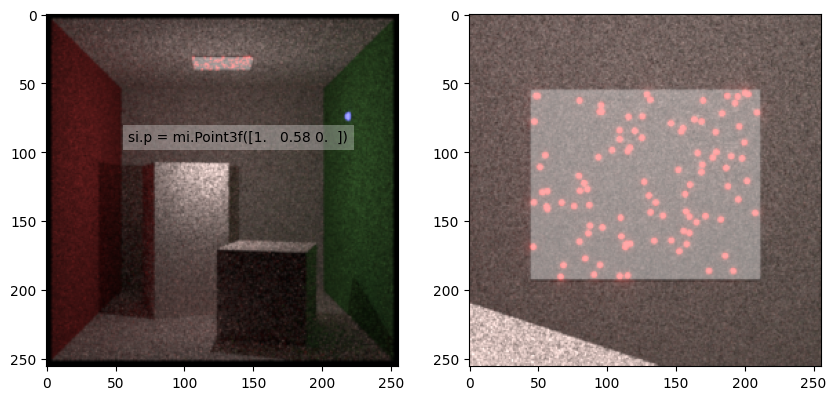

In [ ]:
N = 100
si1 = si # For naming consistency with `si2`, which will be appeared in the next block
ds_list1: list[mi.DirectionSample3f] = []
sampler.seed(0)
for i in range(N):
    ds_temp, _ = scene.sample_emitter_direction(si1, sampler.next_2d())
    ds_list1.append(ds_temp)

plt.figure(figsize=(10,5))
show_ds(si1, ds_list1)
print(f"{ds_list1[0].pdf = }")
print(f"{ds_list1[0].d = }")

Current the distribution of resulting position from `scene.sample_emitter_direction` seems not to depend on the argument `ref=si`. However, the **pdf** which is an attribue of `mi.DirectionSample3f` is with respect to **solid angles** viewed from `ref`, so that it depends on `ref`.
Note that another some attributes of the results such as `ds.d` depend.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.359506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17248301..1.3702222].


ds_list2[0].pdf = 6.012342929840088
ds_list2[0].d = [-0.208542, 0.977001, 0.044485]


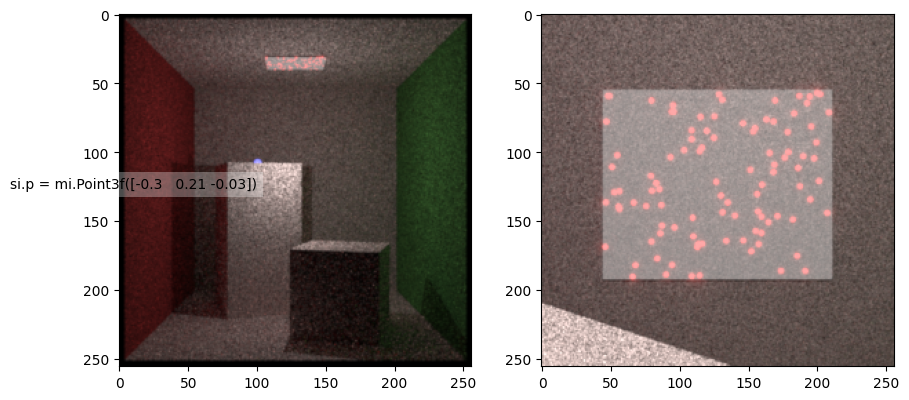

In [9]:
ray2 = mi.Ray3f([-0.3, 0.8, -0.03], [0, -1, 0])
si2 = scene.ray_intersect(ray2)
ds_list2: list[mi.DirectionSample3f] = []
sampler.seed(0)
for i in range(N):
    # ds_temp, _ = scene.sample_emitter_direction(si2, sampler.next_2d())
    ds_temp, _ = scene.sample_emitter_direction(mi.SurfaceInteraction3f(), sampler.next_2d())
    ds_list2.append(ds_temp)

plt.figure(figsize=(10,5))
show_ds(si2, ds_list2)
print(f"{ds_list2[0].pdf = }")
print(f"{ds_list2[0].d = }")

Then what do such *solid angle PDFs viwed from certain points* mean? See the following figure.
![](./figsrc/figure_tutorial4_pdf_areasolang.png)

You can practice such PDF conversion as follows:

In [ ]:
ds1 = ds_list1[0]
ds2 = ds_list2[0]
print(f"Note that `ds1` and `ds2` indicate the same point: {dr.allclose(ds1.p, ds2.p)}\n")

print(f"PDF w.r.t. solid angle from `si1`: {ds1.pdf}")
print(f"PDF w.r.t. solid angle from `si2`: {ds2.pdf}")

Note that `ds1` and `ds2` indicate the same point: True

PDF w.r.t. solid angle from `si1`: 29.106088638305664
PDF w.r.t. solid angle from `si2`: 6.012342929840088


Now lets convert these *PDFs w.r.t. solid angle* into *PDFs w.r.t. area*.

First, note that current Mitsuba 3's `mi.Scene.sample_emitter_direction()` is based on the uniform distribution on area lights, the PDF w.r.t. its area can be computed straightforwardly:

In [29]:
light_tf = mi.cornell_box()['light']['to_world']
print(light_tf)

Transform[
  matrix=[[0.23, 0, 0, 0],
          [0, -8.30516e-09, -0.19, 0.99],
          [0, 0.19, -8.30516e-09, 0.01],
          [0, 0, 0, 1]],
  inverse_transpose=[[4.34783, 0, 0, 0],
                     [0, -2.3006e-07, -5.26316, 0],
                     [0, 5.26316, -2.3006e-07, 0],
                     [0, -0.0526314, 5.21053, 1]]
]


In [30]:
# NOTE: Default size of a `rectangle` shape in Mitsuba 3 is
#       2x2, since each vertex has positions: (-1,-1), (-1,1), (1,-1), (1,1)
rect_a = light_tf.matrix[0, 0] * 2
rect_b = light_tf.matrix[2, 1] * 2
rect_area = rect_a * rect_b
print(f"Rectangle (area light) area: {rect_area}")
pdf_area = 1/rect_area
print(f"PDF w.r.t. area: {pdf_area}")

Rectangle (area light) area: 0.17479998965263377
PDF w.r.t. area: 5.720824137273813


Finally, check we can correctly convert *PDFs w.r.t. solid angle* into *PDFs w.r.t. area*.

In [36]:
def pdf_solang2area(pdf: mi.Float, ds: mi.DirectionSample3f, ref: mi.Interaction3f):
    return pdf * dr.dot(ds.n, -ds.d) / ds.dist**2

print(f"{dr.allclose(pdf_area, pdf_solang2area(ds1.pdf, ds1, si1)) = }")
print(f"{dr.allclose(pdf_area, pdf_solang2area(ds2.pdf, ds2, si2)) = }")

dr.allclose(pdf_area, pdf_solang2area(ds1.pdf, ds1, si1)) = True
dr.allclose(pdf_area, pdf_solang2area(ds2.pdf, ds2, si2)) = True


### Test Visibility
**Caution:** `scene.sample_emitter_direction` is not guaranteed to sample *visible* emitter point. Be careful for the `test_visibility` parameter.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3684088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.20987707..1.3696649].


DirectionSample[
  p=[-0.211317, 0.99, 0.0450768],
  n=[0, -1, -4.37114e-08],
  uv=[0.0406159, 0.592307],
  time=0,
  pdf=24.013,
  delta=0,
  d=[0.191565, 0.980782, 0.037002],
  dist=2.02899,
  emitter=0x2d4eb9686f0
]
weight3 = [0.765709, 0.582488, 0.281246]


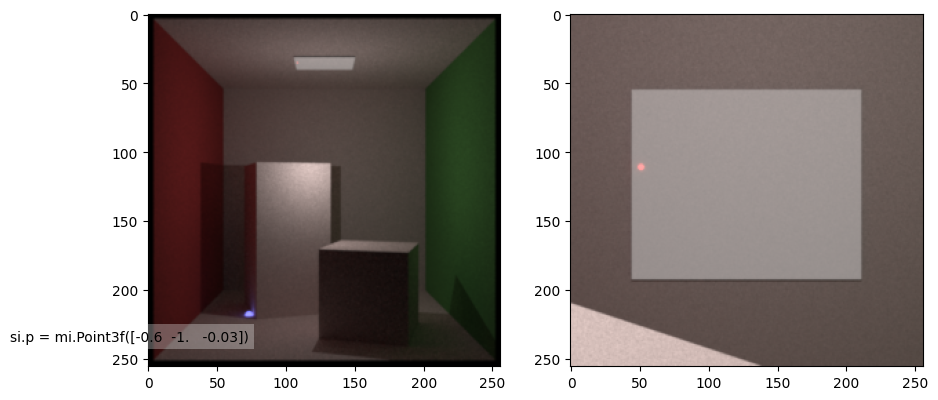

In [7]:
ray3 = mi.Ray3f([-0.6, 0.8, -0.03], [0, -1, 0])
si3 = scene.ray_intersect(ray3)
sampler.seed(0)
# Try to toggle `test_visibility`
ds3, weight3 = scene.sample_emitter_direction(si3, sampler.next_2d(), test_visibility=False)

plt.figure(figsize=(10,5))
show_ds(si3, [ds3])
print(ds3)
print(f"{weight3 = }")